In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
import tensorflow as tf
# Here Resnet50 model is implemented , please try with Resnet50V2 too.

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
        
train_path = './Datasets/Thermal_Fusion(Dataset)/Training/'

In [3]:
# Import the Resnet50 or Resnet50 V2 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

Rsnet50 = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in Rsnet50.layers:
    layer.trainable = False
    
# our layers - you can add more if you want
x = Flatten()(Rsnet50.output)

prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=Rsnet50.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [5]:
# useful for getting number of output classes
folders = glob('./Datasets/Thermal_Fusion(Dataset)/Training/*')

In [6]:
len(folders)

2

In [7]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='Adagrad', #Adamax , RMSprop , Adagrad
  metrics=['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
#Total BFlops
from model_profiler import model_profiler

Batch_size = 32
profile = model_profiler(model, Batch_size)

print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0696        | BFLOPs  |
| GPU Memory Requirement           | 3.7746        | GB      |
| Model Parameters                 | 23.6652       | Million |
| Memory Required by Model Weights | 90.2754       | MB      |


In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 50

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5,1.0],
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./Datasets/Thermal_Fusion(Dataset)/Training/',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'binary')

test_set = validation_datagen.flow_from_directory('./Datasets/Thermal_Fusion(Dataset)/Testing/',
                                            target_size = (224, 224),
                                            batch_size = 50,
                                            class_mode = 'binary')

Found 1204 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [11]:
len(training_set)

25

In [12]:
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

In [13]:
imgs ,labels = next(training_set)

In [14]:
from matplotlib import pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

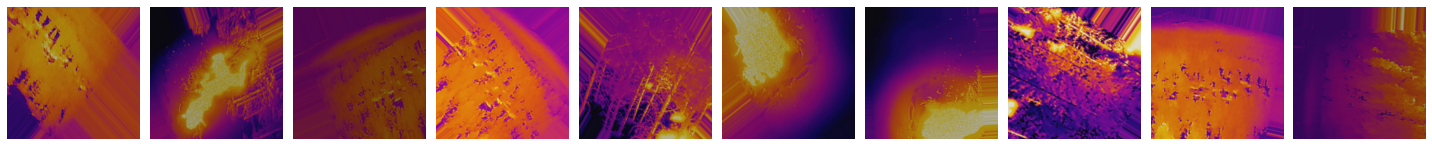

[1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 1.]


In [15]:
plotImages(imgs)
print(labels)

In [246]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint
#filepath='saved_models/models.h5'
filepath="./FirevsNonFire_ResNet50_transfer_learning_model_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [29]:
history = model.fit(training_set,
          steps_per_epoch= 25,
          epochs=5, 
          validation_data=test_set,
          validation_steps= 5)

Epoch 1/5
25/25 [==============================] - 114s 5s/step - loss: 0.1015 - accuracy: 0.9809 - auc: 0.9927 - precision: 0.9769 - recall: 0.9788 - val_loss: 0.0372 - val_accuracy: 0.9954 - val_auc: 0.9948 - val_precision: 0.9916 - val_recall: 1.0000
Epoch 2/5
25/25 [==============================] - 113s 5s/step - loss: 0.1683 - accuracy: 0.9676 - auc: 0.9846 - precision: 0.9669 - recall: 0.9575 - val_loss: 0.0418 - val_accuracy: 0.9954 - val_auc: 0.9949 - val_precision: 0.9916 - val_recall: 1.0000
Epoch 3/5
25/25 [==============================] - 113s 5s/step - loss: 0.0827 - accuracy: 0.9751 - auc: 0.9942 - precision: 0.9710 - recall: 0.9710 - val_loss: 0.0389 - val_accuracy: 0.9954 - val_auc: 0.9949 - val_precision: 0.9916 - val_recall: 1.0000
Epoch 4/5
25/25 [==============================] - 115s 5s/step - loss: 0.0756 - accuracy: 0.9817 - auc: 0.9939 - precision: 0.9769 - recall: 0.9807 - val_loss: 0.0359 - val_accuracy: 0.9954 - val_auc: 0.9949 - val_precision: 0.9916 - val

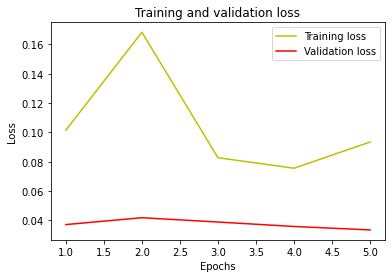

In [30]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

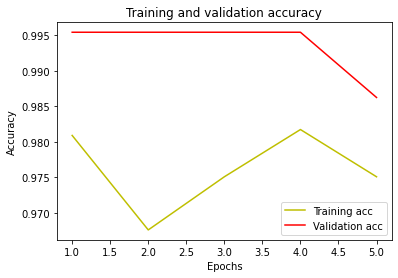

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
from tensorflow.keras.models import load_model

model.save('FirevsNonFire_ResNet50_transfer_learning_model_weights-improvement-09-0.99.hdf5')

-----------------------------------------------------------------------------------------

In [16]:
from tensorflow import keras

model = keras.models.load_model('FirevsNonFire_ResNet50_transfer_learning_model_weights-improvement-07-0.99.hdf5')

In [17]:
model.evaluate(test_set)

5/5 [==============================] - 11s 2s/step - loss: 0.1565 - accuracy: 0.9771 - auc_1: 0.9882 - precision_1: 0.9593 - recall_1: 1.0000


[0.15652455389499664,
 0.9770641922950745,
 0.9882203936576843,
 0.9593495726585388,
 1.0]

In [18]:
test_set.reset() 

In [103]:
pred= model.predict(test_set)
pred_resnet = []
for prediction in pred:
    if  prediction > 0.5:
        prediction = 1
        pred_resnet.append(prediction)
    else:
        prediction = 0
        pred_resnet.append(prediction)

# predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in pred_resnet]
print(pred_resnet)
print(labels)
print(predictions)

[0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]
{'Fire': 0, 'No_Fire': 1}
['Fire', 'No_Fire', 'Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'Fire', 'No_Fire', 'No_Fire', 'Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'Fire', 'No_Fire', 'Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'No_Fire', 'Fire', 'F

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [105]:
# Y_pred = model.predict_generator(test_set)
# y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes,pred_resnet ))
print('Classification Report')
target_names = ['Fire','No_Pile_Fire']
print(classification_report(test_set.classes, pred_resnet, target_names=target_names))

Confusion Matrix
[[43 57]
 [52 66]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.45      0.43      0.44       100
No_Pile_Fire       0.54      0.56      0.55       118

    accuracy                           0.50       218
   macro avg       0.49      0.49      0.49       218
weighted avg       0.50      0.50      0.50       218



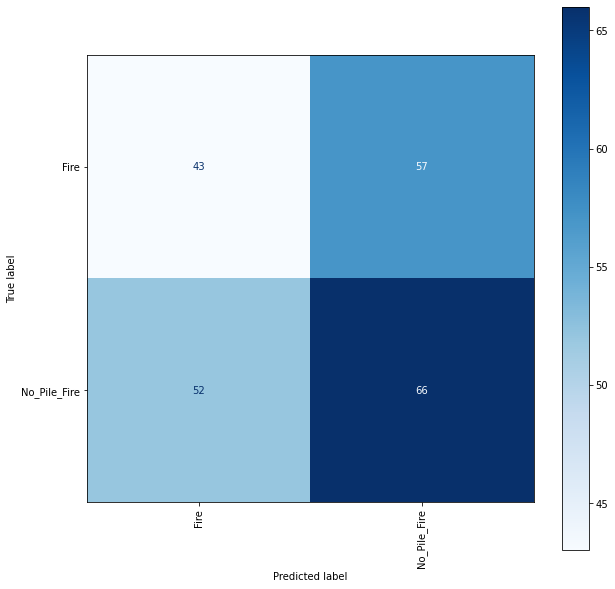

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['Fire','No_Pile_Fire']


cm = confusion_matrix(test_set.classes, pred_resnet)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))

disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation='vertical')

plt.show()

In [81]:
mythreshold=1 # Ideal thresholds
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(test_set)>= mythreshold).astype(int)
cm=confusion_matrix(test_set.classes, y_pred)  
print(cm)

[[71 29]
 [95 23]]


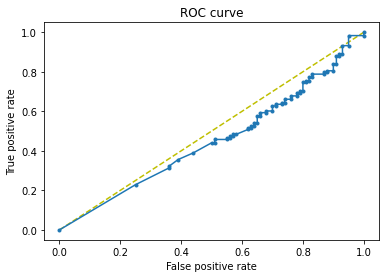

In [82]:
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(test_set).ravel()

fpr, tpr, thresholds = roc_curve(test_set.classes, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [83]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)

print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.45283898305084747
